In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch; print(torch.cuda.is_available())

True


In [3]:

import numpy as np
from pathlib import Path
# name of the file
data_dir = Path('/share/gpu0/asaoulis/cmd/')
IllustrisLH = data_dir / 'params_SB28_IllustrisTNG.txt'
# read the data
IllustrisLHfparams = np.loadtxt(IllustrisLH)[:, :2]

nbodyLH = data_dir / 'params_SB28_Nbody_IllustrisTNG.txt'
nbodyLHfparams = np.loadtxt(nbodyLH)[:, :2]


In [4]:
# load the data
IllustrisLH= data_dir / 'Maps_Mcdm_IllustrisTNG_SB28_z=0.00.npy'
illustris_data = np.load(IllustrisLH)

nbodyLH= data_dir / 'Maps_Mtot_Nbody_IllustrisTNG_SB28_z=0.00.npy'
nbody_data = np.load(nbodyLH)

In [5]:
illustris_data.shape

(30720, 256, 256)

In [6]:
# repeat the params for the number of maps
factor = 15
IllustrisLHfparams_repeated = np.repeat(IllustrisLHfparams, factor, axis=0)
nbodyLHfparams_repeated = np.repeat(nbodyLHfparams, factor, axis=0)

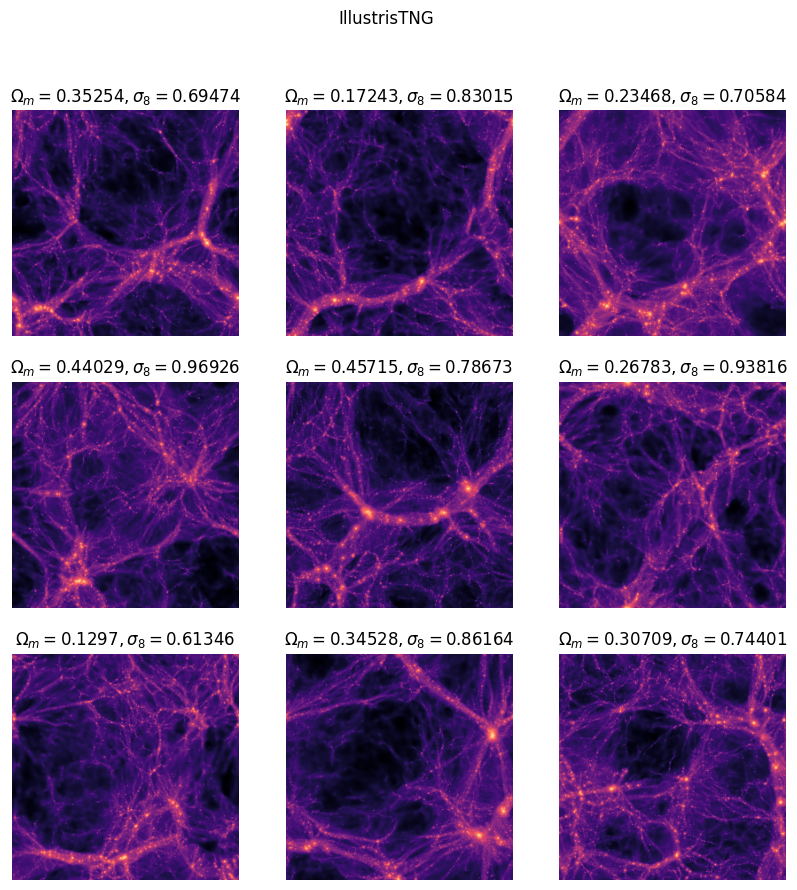

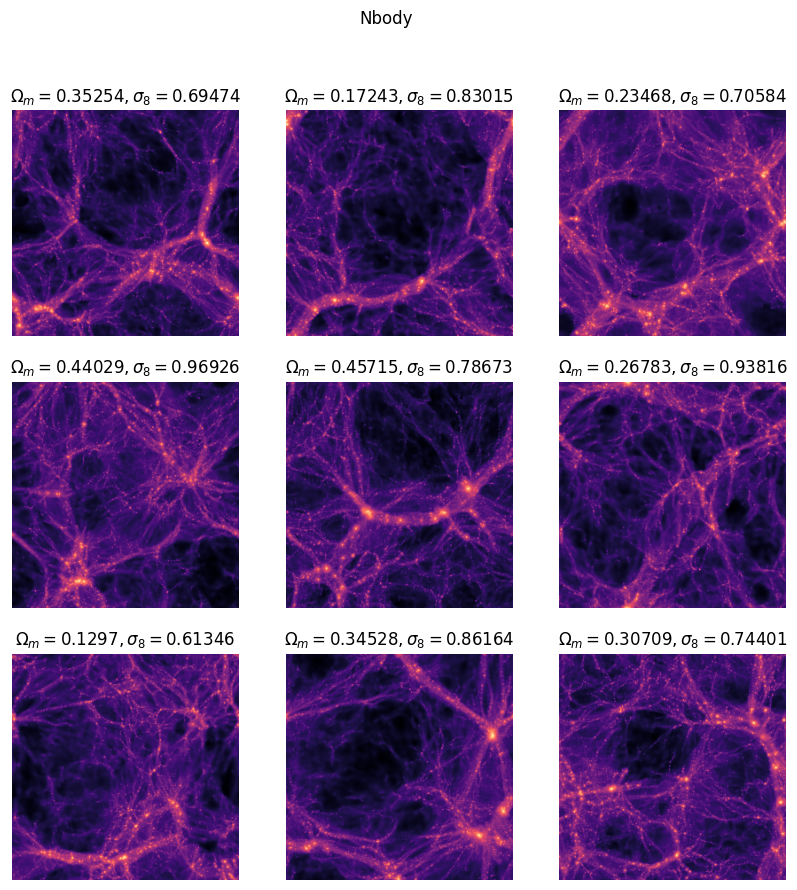

In [7]:
import matplotlib.pyplot as plt
objs = {'IllustrisTNG': (illustris_data, IllustrisLHfparams), 'Nbody': (nbody_data, nbodyLHfparams)}
for name, (data, params) in objs.items():
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        for j in range(3):
            params = IllustrisLHfparams[i*3+j][:2]
            ax[i,j].set_title(f"$\Omega_m = {params[0]}, \sigma_8 = {params[1]}$")
            ax[i, j].imshow(np.log(data[i*3+j]), cmap='magma')
            ax[i, j].axis('off')
    plt.suptitle(name)
            
    plt.show()


In [8]:
from models import MAFPretrainFineTune, TrainConfig

In [9]:

class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None
    def fit(self, X, axis=None):
        if axis is not None:
            self.min = X.min(axis=axis)
            self.max = X.max(axis=axis)
        else:
            self.min = X.min()
            self.max = X.max()
    def transform(self, X):
        return (X - self.min) / (self.max - self.min)
    def inverse_transform(self, X):
        return X * (self.max - self.min) + self.min
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X, axis=None):
        """Compute the mean and standard deviation for scaling."""
        if axis is not None:
            self.mean = X.mean(axis=axis)
            self.std = X.std(axis=axis)
        else:
            self.mean = X.mean()
            self.std = X.std()

    def transform(self, X):
        """Scale the input data using the computed mean and std deviation."""
        return (X - self.mean) / self.std

    def inverse_transform(self, X):
        """Reverse the transformation back to the original scale."""
        return X * self.std + self.mean

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft2, fftshift
from scipy.ndimage import gaussian_gradient_magnitude

def create_dummy_variables(x, y):
    # mean_val = y.mean(axis=(1, 2))
    # var_val = y.var(axis=(1, 2))
    # skew_val = np.array([skew(field.flatten()) for field in y])
    kurt_val = np.array([kurtosis(field.flatten()) for field in y])
    
    fft_power = np.abs(fftshift(fft2(y), axes=(1, 2)))**2
    high_freq_power = fft_power[:, 120:136, 120:136].mean(axis=(1, 2))
    
    grad_mag_mean = np.array([gaussian_gradient_magnitude(field, sigma=1).mean() for field in y])

    x = np.hstack([x,
                   kurt_val[:, None], high_freq_power[:, None], grad_mag_mean[:, None]])
    
    return x, y

nbody_x_repeated = nbodyLHfparams_repeated
illustris_x_repeated = IllustrisLHfparams_repeated
param_scaler = MinMaxScaler()
param_scaler.fit(illustris_x_repeated[:, :2], axis=0)
expensive_x = param_scaler.transform(illustris_x_repeated[:, :2])
cheap_x = param_scaler.transform(nbody_x_repeated[:, :2])

exp_data_scaler = StandardScaler()
exp_data_scaler.fit(np.log(illustris_data))
expensive_y = exp_data_scaler.transform(np.log(illustris_data))

cheap_data_scaler = StandardScaler()
cheap_data_scaler.fit(np.log(nbody_data))
cheap_y = cheap_data_scaler.transform(np.log(nbody_data))


def build_exp_train_test_split(expensive_x, expensive_y, N_TEST):
    test_ids = np.random.choice(expensive_x.shape[0], N_TEST, replace=False)
    train_ids = np.array([i for i in range(expensive_x.shape[0]) if i not in test_ids])
    return expensive_x[train_ids], expensive_y[train_ids], expensive_x[test_ids], expensive_y[test_ids]
np.random.seed(0)
expensive_x, expensive_y, expensive_test_x, expensive_test_y = build_exp_train_test_split(expensive_x, expensive_y, 2000)

cheap_x, cheap_y, cheap_test_x, cheap_test_y = build_exp_train_test_split(cheap_x, cheap_y, 2000)

In [15]:
import os
import torch
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import wandb
import random
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CyclicLR
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms

import compressors as models

# Define the augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Lambda(lambda img: transforms.functional.rotate(img, random.choice([0, 90, 180, 270]))),
])

class AugmentDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

from lightning_modules import RegressionLightningModule, NDELightningModule

def train(model, train_loader, val_loader, epochs=100, logger=None):
    
    monitor_string =f"val_{model.loss_name}"
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor=f"{monitor_string}",
        dirpath=f"/share/gpu0/asaoulis/cmd/checkpoints/run_test",
        filename=f"checkpoint-{{epoch:02d}}-{{{monitor_string}:.4f}}",
        save_top_k=10,
        mode="min",
    )
    lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')  # or 'epoch'
    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        log_every_n_steps=10,  # Logs every 10 steps
        check_val_every_n_epoch=1,  # Ensures validation runs in every epoch
        val_check_interval=50,  # Runs validation every 25 training steps
        logger=pl.loggers.WandbLogger() if logger else None,
        callbacks=[checkpoint_callback, lr_monitor]
    )
    trainer.fit(model, train_loader, val_loader)

def build_pl_model(embedding_net, latent_dim, x, y, testxy, batch_size, lr, scheduler_type, num_extra_blocks=0, checkpoint_path = None, optimizer_kwargs = {}):
    dataset = AugmentDataset(x, y, train_transform)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    test_x, test_y = testxy
    test_dataset = TensorDataset(test_x, test_y)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

    model = NDELightningModule(embedding_net, conditioning_dim=latent_dim, lr=lr, scheduler_type=scheduler_type, batch_size=batch_size,
                                    element_names= ["Omega", "sigma8"], test_dataloader = test_loader, 
                                    num_extra_blocks=num_extra_blocks, checkpoint_path=checkpoint_path,
                                    optimizer_kwargs = optimizer_kwargs)
                                    
    return train_loader,val_loader,model




In [ ]:
# Run training
dataset_size = 600
lr = 0.0045
latent_dim = 2
# 'cosine', 'cosine_2mult',
for scheduler_type in [ 'cyclic']: 
    for i in range(3):
        ids = np.random.permutation(expensive_x.shape[0])
        cheap_train_x_data = torch.tensor(expensive_x[ids], dtype=torch.float32)[:dataset_size, :2]
        cheap_train_y_data = torch.tensor(expensive_y[ids], dtype=torch.float32)[:dataset_size].unsqueeze(1)
        testxy = (
            torch.tensor(expensive_test_y, dtype=torch.float32).unsqueeze(1),
            torch.tensor(expensive_test_x[:, :2], dtype=torch.float32)
        )
        
        embedding_model = models.build_resnet(latent_dim, pretrained=True).to(device='cuda')
        train_loader, val_loader, model = build_pl_model(embedding_model, latent_dim, cheap_train_y_data, cheap_train_x_data, testxy, batch_size=10, lr=lr, scheduler_type=scheduler_type)
        # resnet = model_o3_err(2, hidden=12).to(device='cuda')
        try:
            logger = wandb.init(project="camels-nbody-illustris-improved", name=f"nde_resnet_{scheduler_type}_ds{dataset_size}_{i}", reinit=True)
            trained_model = train(model, train_loader, val_loader, epochs=50, logger=logger)
        except Exception as e:
            import traceback
            traceback.print_exception()

In [ ]:
# Run training
dataset_size = 28000
lr = 0.0045
# 'cosine', 'cosine_2mult',
for scheduler_type in [ 'cyclic']: 
    for i in range(1):
        ids = np.random.permutation(cheap_x.shape[0])
        cheap_train_x_data = torch.tensor(cheap_x[ids], dtype=torch.float32)[:dataset_size, :2]
        cheap_train_y_data = torch.tensor(cheap_y[ids], dtype=torch.float32)[:dataset_size].unsqueeze(1)
        testxy = (
            torch.tensor(cheap_test_y, dtype=torch.float32).unsqueeze(1),
            torch.tensor(cheap_test_x[:, :2], dtype=torch.float32)
        )

        # resnet = model_o3_err(2, hidden=12).to(device='cuda')
        try:
            logger = wandb.init(project="camels-nbody-illustris-improved", name=f"pretrain_nde_resnet_{scheduler_type}_{i}", reinit=True)
            trained_model = train(cheap_train_y_data, cheap_train_x_data, testxy, epochs=50, batch_size=128, lr=lr, logger=logger, scheduler_type=scheduler_type)
        except Exception as e:
            import traceback
            traceback.print_exception()

In [33]:
ckpt_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=22-val_log_prob=-2.7849.ckpt"

In [41]:
latent_dim =2
resnet = models.build_resnet(latent_dim, pretrained=True).to(device='cuda')
test_x, test_y = testxy
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=8)
model = NDELightningModule.load_from_checkpoint(ckpt_path, model=resnet, conditioning_dim=latent_dim, lr=lr, scheduler_type=scheduler_type, batch_size=128,
                                element_names= ["Omega", "sigma8"], test_dataloader = test_loader)

Finished model setup


In [ ]:
### ANNEALING CHEAP SIMS

# Run training
dataset_size = 28000
lr = 0.00005
# latent_dim = 2
latent_dim = 128
# pretrain_checkpoint_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=15-val_log_prob=-3.1550.ckpt" # no wd
pretrain_checkpoint_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_pretrain_nde_resnset_wd_cyclic_2/checkpoint-epoch=30-val_log_prob=-3.0244.ckpt" # wd

# 'cosine', 'cosine_2mult',
for scheduler_type in [ 'exp']: 
    for i in range(1):
        ids = np.random.permutation(cheap_x.shape[0])
        cheap_train_x_data = torch.tensor(cheap_x[ids], dtype=torch.float32)[:dataset_size, :2]
        cheap_train_y_data = torch.tensor(cheap_y[ids], dtype=torch.float32)[:dataset_size].unsqueeze(1)
        testxy = (
            torch.tensor(cheap_test_y, dtype=torch.float32).unsqueeze(1),
            torch.tensor(cheap_test_x[:, :2], dtype=torch.float32)
        )
        
        embedding_model = models.build_resnet(latent_dim, pretrained=True).to(device='cuda')
        train_loader, val_loader, model = build_pl_model(embedding_model, latent_dim, cheap_train_y_data, cheap_train_x_data, testxy, 
                                                         batch_size=128, lr=lr, scheduler_type=scheduler_type, checkpoint_path=pretrain_checkpoint_path,
                                                         optimizer_kwargs = dict(weight_decay=0.01, betas=(0.9, 0.999)))
        model.append_maf_blocks(cheap_train_x_data, cheap_train_y_data, num_extra_blocks=0, bounds=(0,1), device='cuda')
        # resnet = model_o3_err(2, hidden=12).to(device='cuda')
        try:
            logger = wandb.init(project="camels-nbody-illustris-improved", name=f"anneal_nde_resnet_{scheduler_type}_ds{dataset_size}_{i}", reinit=True)
            trained_model = train(model, train_loader, val_loader, epochs=50, logger=logger)
        except Exception as e:
            import traceback
            traceback.print_exception()

In [21]:
# FINETUNING STAGE 
dataset_size = 600
lr = 0.000001#
# latent_dim = 2
latent_dim = 128
# pretrain_checkpoint_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=15-val_log_prob=-3.1550.ckpt" # no wd
# pretrain_checkpoint_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_pretrain_nde_resnset_wd_cyclic_0/checkpoint-epoch=22-val_log_prob=-3.0133.ckpt" # no wd 2
pretrain_checkpoint_path = "/share/gpu0/asaoulis/cmd/checkpoints/run_pretrain_nde_resnset_wd_cyclic_1/checkpoint-epoch=30-val_log_prob=-3.0532.ckpt"

# 'cosine', 'cosine_2mult',
extra_blocks = 0
for scheduler_type in [ 'exp']: 
    for i in range(3):
        ids = np.random.permutation(expensive_x.shape[0])
        cheap_train_x_data = torch.tensor(expensive_x[ids], dtype=torch.float32)[:dataset_size, :2]
        cheap_train_y_data = torch.tensor(expensive_y[ids], dtype=torch.float32)[:dataset_size].unsqueeze(1)
        testxy = (
            torch.tensor(expensive_test_y, dtype=torch.float32).unsqueeze(1),
            torch.tensor(expensive_test_x[:, :2], dtype=torch.float32)
        )
        
        embedding_model = models.build_resnet(latent_dim, pretrained=True).to(device='cuda')
        train_loader, val_loader, model = build_pl_model(embedding_model, latent_dim, cheap_train_y_data, cheap_train_x_data, testxy, 
                                                         batch_size=10, lr=lr, scheduler_type=scheduler_type, 
                                                         checkpoint_path=pretrain_checkpoint_path, 
                                                         optimizer_kwargs = dict(weight_decay=0.01, betas=(0.5, 0.999)))
        model.append_maf_blocks(cheap_train_x_data, cheap_train_y_data, num_extra_blocks=extra_blocks, bounds=(0,1), device='cuda',)
        # resnet = model_o3_err(2, hidden=12).to(device='cuda')
        try:
            logger = wandb.init(project="camels-nbody-illustris-improved", name=f"finetune_nde_resnet_eb{extra_blocks}_{scheduler_type}_ds{dataset_size}_{i}", reinit=True)
            trained_model = train(model, train_loader, val_loader, epochs=50, logger=logger)
        except Exception as e:
            import traceback
            traceback.print_exception()

Finished model setup
Loaded model from /share/gpu0/asaoulis/cmd/checkpoints/run_pretrain_nde_resnset_wd_cyclic_1/checkpoint-epoch=30-val_log_prob=-3.0532.ckpt


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr-AdamW,▂▃▄▅██▇▇▆▆▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_log_prob,▆▅▇▆▆▇▆▂▁███▆▇▇█▇▇▇▇██▇▇▇▅█▆█▇█▆██▇▅▅▇▇█
train_log_prob,▁▄█▂▆▆▄▃▃▂▆▃▂▅▂▇▇▃▆▃▄▅▄▅▂▁▅▃▂▁▁▂▁▄▁▂▁▇▃▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_log_prob,▄█▃▂▆▄▆▄█▂▂▂▅▃▂▂▄▅▂▂▃▃▃▄▁▄▄▃▂▃▅▃▂▂▇▃▁▂▅▂
epoch,46
lr-AdamW,0.0
test_log_prob,2.5617
train_log_prob,-2.13313
trainer/global_step,2529


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Flow | 11.7 M | train
---------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.871    Total estimated model params size (MB)
169       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


{'weight_decay': 0.01, 'betas': (0.5, 0.999)}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Finished model setup
Loaded model from /share/gpu0/asaoulis/cmd/checkpoints/run_pretrain_nde_resnset_wd_cyclic_1/checkpoint-epoch=30-val_log_prob=-3.0532.ckpt


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
lr-AdamW,▁▂▂▃▃▅▅▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
test_log_prob,▄▅▂▁▃▄▅▆▄▆▅▆▆▇▃▇▇▇█▇█▇▆▇▅███▇▆▇▇▇▆▆██▆██
train_log_prob,▆▅▅▃▅█▁▇█▃▆▆▃▂▇▄▅▁▄▂▄▃▃▃▂▁▂█▂▂▂▄▂▄▁▁▃▃▅▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
val_log_prob,▅▃█▇▄▄▅▄▄▃▃▄▂▅▂▃▃▂▂▂▂▃▃▃▁▂▂▃▃▂▂▃▃▂▁▂▃▂▂▁
epoch,49
lr-AdamW,0.0
test_log_prob,2.55769
train_log_prob,-0.07815
trainer/global_step,2699


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Flow | 11.7 M | train
---------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.871    Total estimated model params size (MB)
169       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


{'weight_decay': 0.01, 'betas': (0.5, 0.999)}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Received SIGTERM: 15

Detected KeyboardInterrupt, attempting graceful shutdown ...
[rank: 0] Received SIGTERM: 15
Bypassing SIGTERM: 15


TypeError: print_exception() missing 1 required positional argument: 'exc'

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f6ed721bb20>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f6ed0c6d900, execution_count=21 error_before_exec=None error_in_exec=print_exception() missing 1 required positional argument: 'exc' info=<ExecutionInfo object at 7f6ed0c6ce50, raw_cell="# FINETUNING STAGE 
dataset_size = 600
lr = 0.0000.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bhypatia-login.hpc.phys.ucl.ac.uk/home/asaoulis/projects/transfer_sbi/transfer/camels_test.ipynb#X20sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [13]:
model_checkpoints = {"Finetune": "/share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=49-val_log_prob=-2.0779.ckpt",
                     "Scratch": "/share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=27-val_log_prob=-1.5269.ckpt"}

In [24]:
from models import utils, CustomSNPE_C
import compressors as models
dataset_size=600
latent_dim =2
ids = np.random.permutation(expensive_x.shape[0])
cheap_train_x_data = torch.tensor(expensive_x[ids], dtype=torch.float32)[:dataset_size, :2]
cheap_train_y_data = torch.tensor(expensive_y[ids], dtype=torch.float32)[:dataset_size].unsqueeze(1)
testxy = (
    torch.tensor(expensive_test_y, dtype=torch.float32).unsqueeze(1),
    torch.tensor(expensive_test_x[:, :2], dtype=torch.float32)
)
lr = 0.0045
scheduler_type = 'cyclic'
models_dict = {}
for name, ckpt_path in model_checkpoints.items():
    if 'finetune' in name.lower():
        num_extra_blocks = 2
    else:
        num_extra_blocks = 0
    prior = utils.BoxUniform(low=0 * torch.ones(2), high=1. * torch.ones(2), device="cuda")
    inference_method = CustomSNPE_C(prior=prior, device='cuda')
    inference_method.append_simulations(cheap_train_x_data, cheap_train_y_data)
    embedding_model = models.build_resnet(latent_dim, pretrained=True).to(device='cuda')
    train_loader, val_loader, model = build_pl_model(embedding_model, cheap_train_y_data, cheap_train_x_data, testxy, 
                                                        batch_size=128, lr=lr, scheduler_type=scheduler_type, checkpoint_path=ckpt_path, num_extra_blocks=num_extra_blocks)
    accurate_posterior_sbi = inference_method.build_posterior(model.model.to('cuda'))
    
    models_dict[name] = accurate_posterior_sbi


Finished model setup
Training identity maf blocks
Reinitializing due to high loss...; inf
Reinitializing due to high loss...; 0.05499248579144478
Reinitializing due to high loss...; 0.011972363106906414
Reinitializing due to high loss...; 0.010095829144120216
Reached acceptable loss: 0.008666357956826687
Loaded model from /share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=49-val_log_prob=-2.0779.ckpt
Finished model setup
Loaded model from /share/gpu0/asaoulis/cmd/checkpoints/run_test/checkpoint-epoch=27-val_log_prob=-1.5269.ckpt


Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

/home/asaoulis/.conda/envs/transfer-sbi/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Parameter $\sigma_8$ in chain Scratch is not constrained


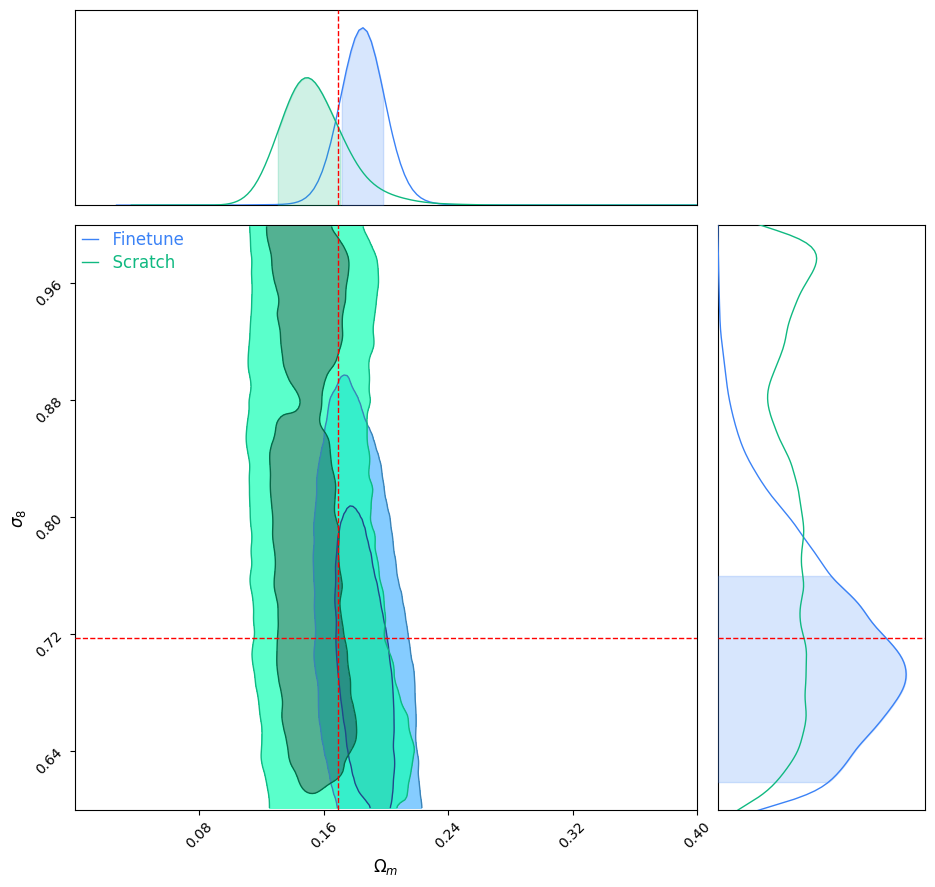

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Parameter $\sigma_8$ in chain Scratch is not constrained


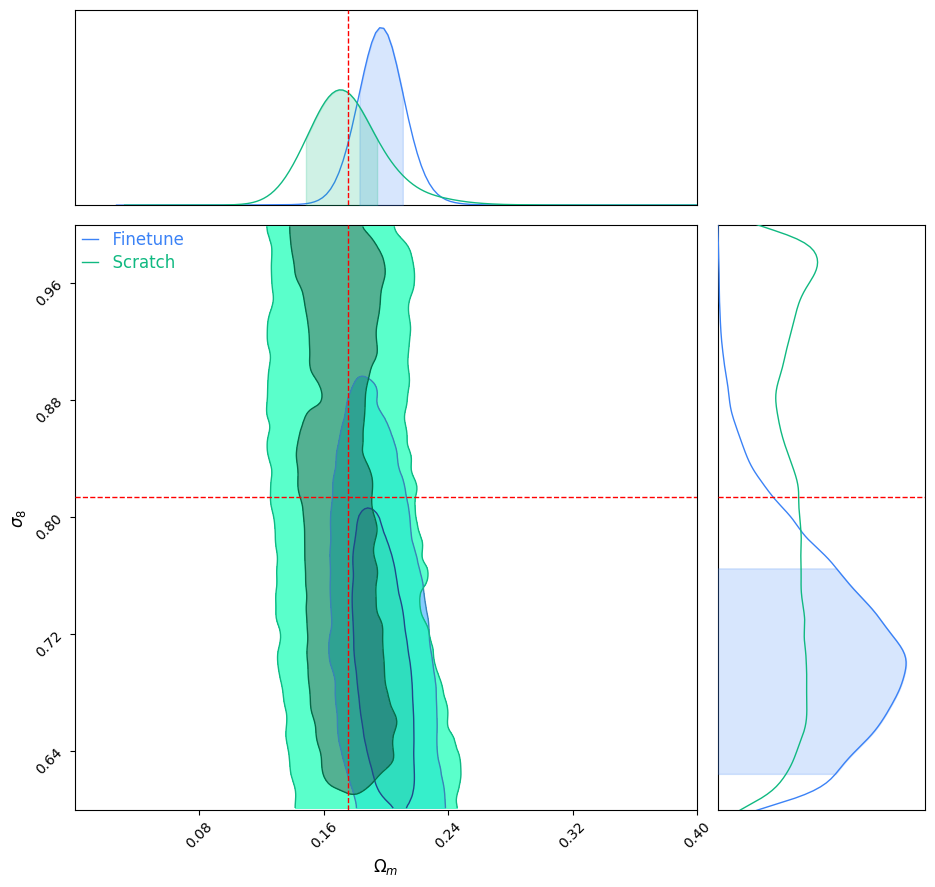

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Parameter $\sigma_8$ in chain Scratch is not constrained


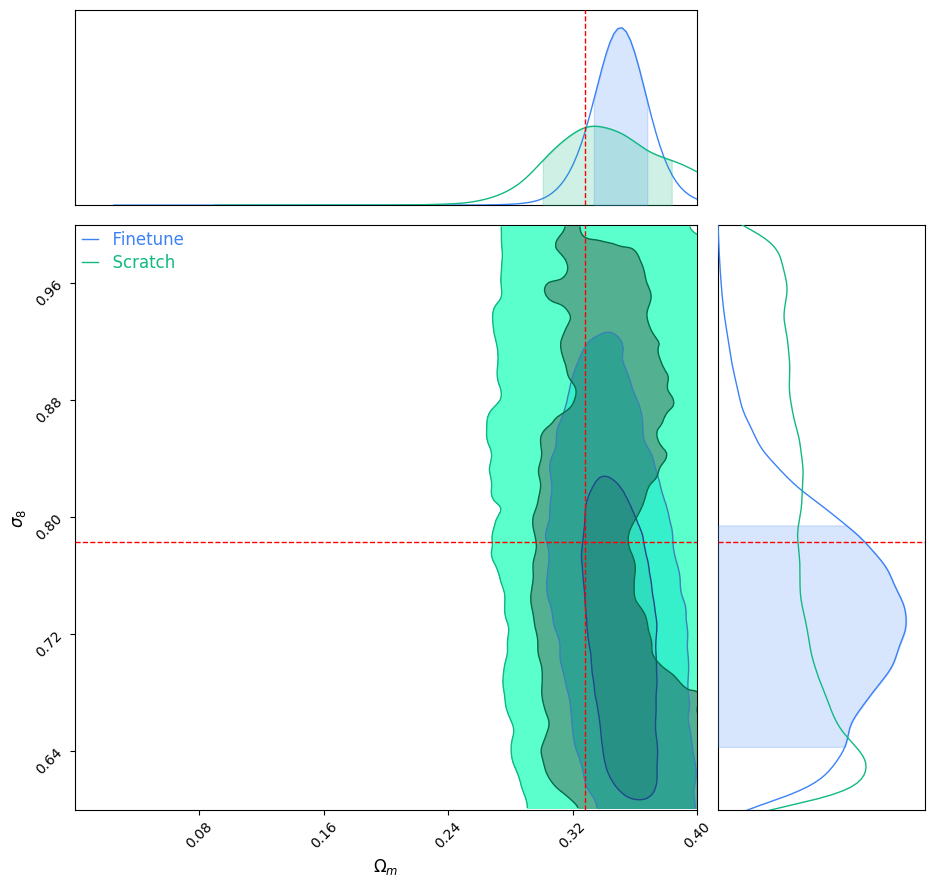

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Parameter $\sigma_8$ in chain Scratch is not constrained


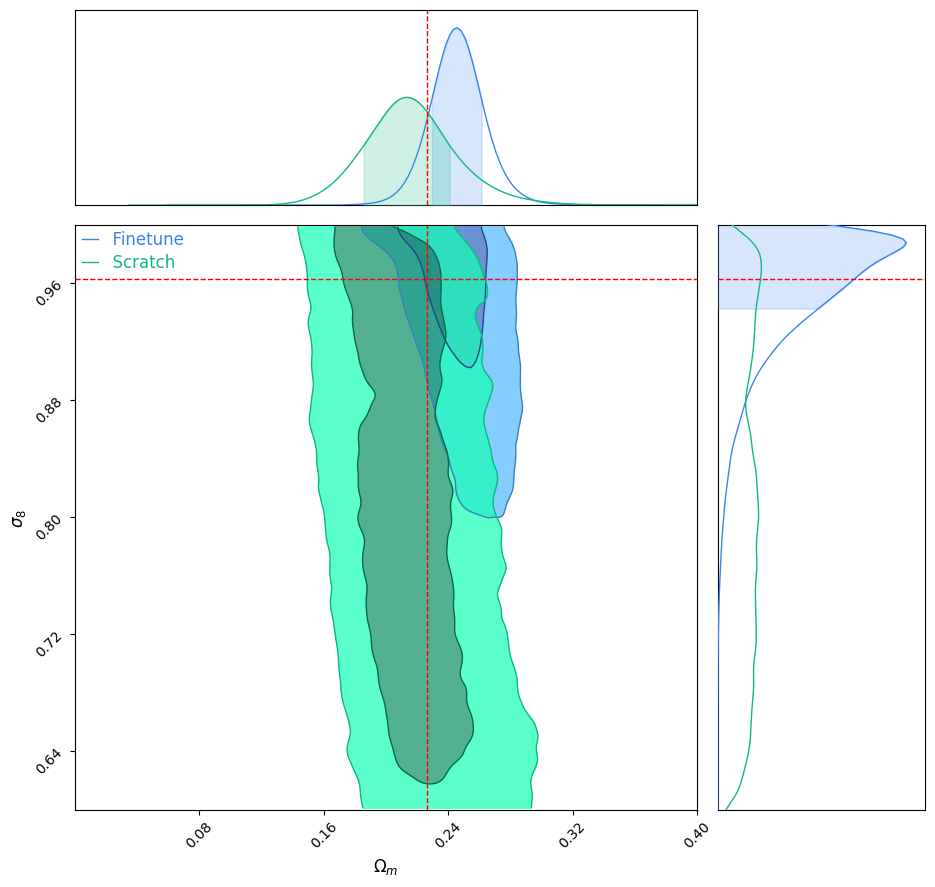

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

Parameter $\sigma_8$ in chain Scratch is not constrained


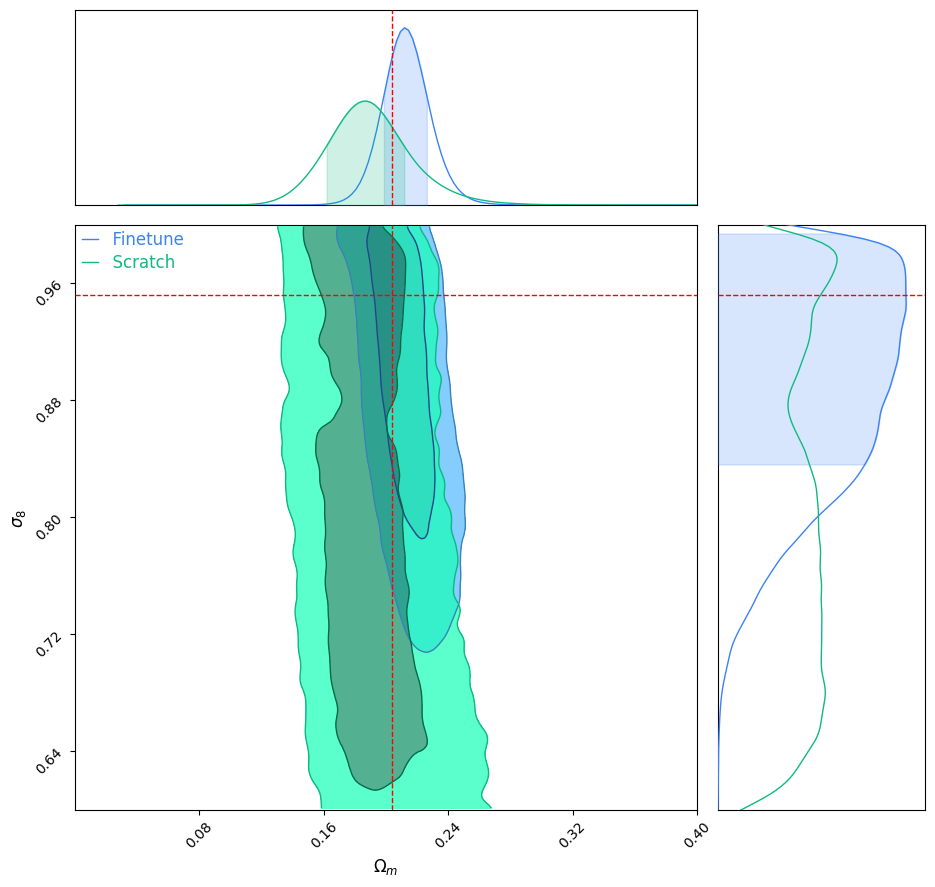

In [25]:
from chainconsumer import Chain, PlotConfig, Truth, ChainConsumer
import pandas as pd

columns = ["$\Omega_m$", "$\sigma_8$"]#, 'power', 'skew']
for i in range(5):
    y = torch.tensor(expensive_test_y[-i]).unsqueeze(0).unsqueeze(0).to('cuda', dtype=torch.float32)
    x = param_scaler.inverse_transform(expensive_test_x[-i])

    c = ChainConsumer()
    for name, accurate_posterior_sbi in models_dict.items():
        samples_cheap= accurate_posterior_sbi.sample((50000,), x=y)

        vals = samples_cheap.detach().cpu().numpy()
        vals = param_scaler.inverse_transform(vals)[:, :2]
        cheap_samples_df = pd.DataFrame(vals, columns=columns)
        cheap_samples = Chain(samples=cheap_samples_df, parameters=columns, name=name)
        c.add_chain(cheap_samples)

    c.set_plot_config(
        PlotConfig(
            flip=True,
            contour_label_font_size=12,
            # put legend in top right c
            extents={"$\Omega_m$":(0, 0.4), "$\sigma_8$":(0.6, 1.)},
            legend_kwargs={"loc": "upper left"},
        )
    )
    truth_dict = {column: x[i]  for i, column in enumerate(columns)}
    c.add_truth(Truth(location=truth_dict, marker="x", color="red", label="Truth"))
    # set extent of the plot

    fig = c.plotter.plot(figsize=(10,10))
    plt.show()